In [227]:
import numpy as np
from numpy import sin,arcsin, cos,pi
from scipy.integrate import odeint, solve_ivp
from scipy.linalg import *
from scipy.optimize import fsolve,root
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib import animation
from IPython.display import HTML
import sympy

In [228]:
q = sympy.var(['q_'+str(i) for i in range(9)])
q = sympy.Matrix(q)
dq = sympy.var(['\dot{q}_'+str(i) for i in range(9)])
dq = sympy.Matrix(dq)
q

Matrix([
[q_0],
[q_1],
[q_2],
[q_3],
[q_4],
[q_5],
[q_6],
[q_7],
[q_8]])

In [229]:
sympy.var('L1,L2,M1,M2,M3 ,x, t')

A = lambda theta: sympy.Matrix([[sympy.cos(theta), -sympy.sin(theta)],
                                [sympy.sin(theta), sympy.cos(theta)]])
C1 = sympy.Matrix([q[0], q[1]]) + A(q[2])*sympy.Matrix([-L1/2,0])
C2 = sympy.Matrix([q[0], q[1]]) + A(q[2])*sympy.Matrix([L1/2,0]) -sympy.Matrix([q[3], q[4]])- A(q[5])*sympy.Matrix([-L2/2,0])
C3 = sympy.Matrix([q[3], q[4]]) + A(q[5])*sympy.Matrix([L2/2,0]) - sympy.Matrix([q[6], q[7]])
C4 = sympy.Matrix([q[7],q[8]])
C  = sympy.Matrix([[C1],[C2],[C3],[C4]])
C_link = sympy.lambdify((q, t, M1, M2, M3, L1, L2), C, 'numpy')

print("Constraint Vector")
C

Constraint Vector


Matrix([
[                     -L1*cos(q_2)/2 + q_0],
[                     -L1*sin(q_2)/2 + q_1],
[L1*cos(q_2)/2 + L2*cos(q_5)/2 + q_0 - q_3],
[L1*sin(q_2)/2 + L2*sin(q_5)/2 + q_1 - q_4],
[                L2*cos(q_5)/2 + q_3 - q_6],
[                L2*sin(q_5)/2 + q_4 - q_7],
[                                      q_7],
[                                      q_8]])

In [230]:
Ct = sympy.diff(C, t)

Ct_link = sympy.lambdify((q, t, M1, M2, M3, L1, L2), Ct, 'numpy')

Ct

Matrix([
[0],
[0],
[0],
[0],
[0],
[0],
[0],
[0]])

In [231]:
Cq = C.jacobian(q)

Cq_link = sympy.lambdify((q, t, M1, M2, M3, L1, L2), Cq, 'numpy')
print("Jacobian Matrix")
Cq

Jacobian Matrix


Matrix([
[1, 0,  L1*sin(q_2)/2,  0,  0,              0,  0,  0, 0],
[0, 1, -L1*cos(q_2)/2,  0,  0,              0,  0,  0, 0],
[1, 0, -L1*sin(q_2)/2, -1,  0, -L2*sin(q_5)/2,  0,  0, 0],
[0, 1,  L1*cos(q_2)/2,  0, -1,  L2*cos(q_5)/2,  0,  0, 0],
[0, 0,              0,  1,  0, -L2*sin(q_5)/2, -1,  0, 0],
[0, 0,              0,  0,  1,  L2*cos(q_5)/2,  0, -1, 0],
[0, 0,              0,  0,  0,              0,  0,  1, 0],
[0, 0,              0,  0,  0,              0,  0,  0, 1]])

In [232]:
Qd = -(Cq*dq).jacobian(q)*dq - 2*sympy.diff(Cq, t)*dq - sympy.diff(C, t, 2)

Qd_link = sympy.lambdify((q, dq, t, M1, M2, M3, L1, L2), Qd, 'numpy')
print("Qd Matrix")
Qd

Qd Matrix


Matrix([
[                            -L1*\dot{q}_2**2*cos(q_2)/2],
[                            -L1*\dot{q}_2**2*sin(q_2)/2],
[L1*\dot{q}_2**2*cos(q_2)/2 + L2*\dot{q}_5**2*cos(q_5)/2],
[L1*\dot{q}_2**2*sin(q_2)/2 + L2*\dot{q}_5**2*sin(q_5)/2],
[                             L2*\dot{q}_5**2*cos(q_5)/2],
[                             L2*\dot{q}_5**2*sin(q_5)/2],
[                                                      0],
[                                                      0]])

In [233]:
M = sympy.Matrix([[M1,0,0,0,0,0,0,0,0],
                 [0,M1,0,0,0,0,0,0,0],
                 [0,0,M1*L1**2/12,0,0,0,0,0,0],
                 [0,0,0,M2,0,0,0,0,0],
                 [0,0,0,0,M2,0,0,0,0],
                 [0,0,0,0,0,M2*L2**2/12,0,0,0],
                 [0,0,0,0,0,0,M3,0,0],
                 [0,0,0,0,0,0,0,M3,0],
                 [0,0,0,0,0,0,0,0,0]])

LHS =  sympy.BlockMatrix([[M,Cq.transpose()],[Cq,sympy.zeros(8)]])
LHS_link = sympy.lambdify((q, M1, M2, M3, L1, L2), LHS)
LHS

Matrix([
[Matrix([
[M1,  0,           0,  0,  0,           0,  0,  0, 0],
[ 0, M1,           0,  0,  0,           0,  0,  0, 0],
[ 0,  0, L1**2*M1/12,  0,  0,           0,  0,  0, 0],
[ 0,  0,           0, M2,  0,           0,  0,  0, 0],
[ 0,  0,           0,  0, M2,           0,  0,  0, 0],
[ 0,  0,           0,  0,  0, L2**2*M2/12,  0,  0, 0],
[ 0,  0,           0,  0,  0,           0, M3,  0, 0],
[ 0,  0,           0,  0,  0,           0,  0, M3, 0],
[ 0,  0,           0,  0,  0,           0,  0,  0, 0]]), Matrix([
[            1,              0,              1,             0,              0,             0, 0, 0],
[            0,              1,              0,             1,              0,             0, 0, 0],
[L1*sin(q_2)/2, -L1*cos(q_2)/2, -L1*sin(q_2)/2, L1*cos(q_2)/2,              0,             0, 0, 0],
[            0,              0,             -1,             0,              1,             0, 0, 0],
[            0,              0,              0,            -1,         

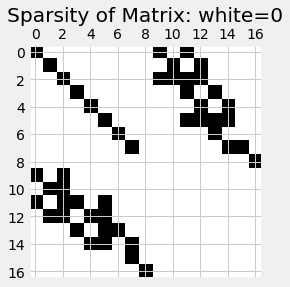

In [234]:

plt.spy(LHS_link(np.ones(9), 1, 1, 1, 1, 1))
plt.title('Sparsity of Matrix: white=0');

In [235]:
M1 = 0.5
M2 = 1
M3 = 0.2
L1 = 0.2
L2 = 0.4

Mo = 10
F  = 15

def ode_bar(t, y, alpha = 0.1, beta = 0.2, baumgarte = True):
    '''
    dy, L = ode_bar(t, y)
    returns the derivative of state, y, and the generalized reaction forces as L 
    for a given time, t
    
    Parameters
    ----------
    t : current time
    y : current state of pinned link, [Rx, Ry, theta, vx, vy, dtheta/dt]
    alpha : Baumgarte stabilization parameter for velocity constraints
    beta : Baumgarte stabilization parameter for position constraints
    baumgarte : default = True, adds the stabilization to the constraint forces `Qd`
                `Qd = Qd-2*alpha*(Cq@y2+Ct)-beta**2*C`
    
    Returns
    -------
    dy : derivative of state of pinned link, [vx, vy, dtheta/dt, ax, ay, ddtheta/ddt]
    L : Lagrange multipliers that represent the reaction forces and moments, -Cq@L = Qc
    '''
    
    dy = np.zeros(y.shape)

    y1, y2 = np.array_split(y, 2)
    dy[0:len(y2)] = y2    

    M = np.diag([M1, M1, M1*L1**2/12,M2, M2, M2*L2**2/12,M3, M3, 0])
    C = C_link(y1, t,  M1, M2, M3, L1, L2)[:,0] 
    Ct = Ct_link(y1, t,  M1, M2, M3, L1, L2)[:, 0]
    Cq = Cq_link(y1, t,  M1, M2, M3, L1, L2)

    nc, n = np.shape(Cq) 
    A = np.block([[M, Cq.T], 
              [Cq, np.zeros((nc,nc))]])
    Qe = np.array([0, 0, Mo, 0, 0, 0, F, 0, 0])

    Qd = Qd_link(y1, y2, t, M1, M2, M3, L1, L2)[:, 0]
    if baumgarte == True:
        Qd = Qd-2*alpha*(Cq@y2+Ct)-beta**2*C


    Q=np.hstack((Qe,Qd))
    x=np.linalg.solve(A,Q)
    
    dy[len(y2):]=x[0:len(y2)]
    L = x[len(y2):]
    return dy, L

In [240]:
t = np.linspace(0,1,200)
h = t[1]-t[0]
theta0 = 0 
q0 = fsolve(lambda q: np.hstack([C_link(q, 0, M1, M2, M3, L1, L2)[:,0], q[2]-theta0]), np.zeros(9))
y0 = np.zeros(18)
dq0 = np.linalg.solve(np.vstack([Cq_link(q0, 0, M1, M2, M3, L1, L2), np.array([0, 0, 1, 0, 0, 0, 1, 0 ,0])]), 
                      np.vstack([-Ct_link(q0, 0, M1, M2, M3, L1, L2), 0]))

y0[0:9] = q0.reshape(9, )
y0[9:] = dq0.reshape(9, )

sol = solve_ivp(lambda t,y: ode_bar(t,y,1/h,np.sqrt(2)/h)[0],\
            y0 = y0,t_span=[0,t.max()],t_eval=t)

Text(0, 0.5, '$\\theta^1$')

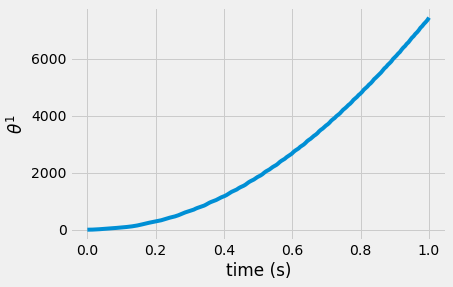

In [246]:
plt.plot(t, sol.y[2]*180/pi)
plt.xlabel('time (s)')
plt.ylabel(r'$\theta^1$')

Text(0, 0.5, '$\\theta^2$')

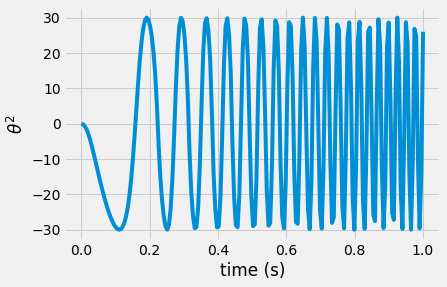

In [249]:
plt.plot(t, sol.y[5]*180/pi)
plt.xlabel('time (s)')
plt.ylabel(r'$\theta^2$')

Text(0, 0.5, 'Displacement (m)')

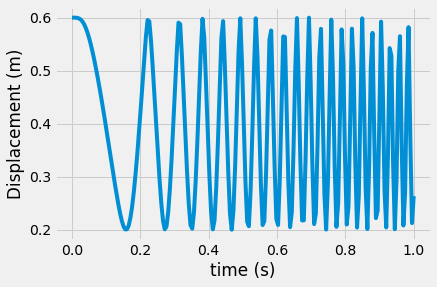

In [253]:
plt.plot(t, sol.y[6])
plt.xlabel('time (s)')
plt.ylabel('Displacement (m)')